In [1]:
from __future__ import print_function

import pandas as pd
import numpy as np
import os
import re

import matplotlib.pyplot as plt
%matplotlib inline

import keras
from keras.datasets import mnist
from keras.models import Sequential,Input,Model
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras.layers.advanced_activations import LeakyReLU
from keras.utils import to_categorical
from keras import backend as K

from google.colab import drive

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.cross_validation import train_test_split
from sklearn.metrics import classification_report

from timeit import default_timer as timer

Using TensorFlow backend.
/usr/local/lib/python3.6/dist-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [3]:
# Levantamos el dataframe con las imagenes
drive.mount('/content/gdrive')

# Leandro
#with open('/content/gdrive/My Drive/mercadolibre/data_frame_imagenes', 'r') as f:

# Ivan
with open('/content/gdrive/My Drive/DSS 2018/DSS TPFinal/mercadolibre/data_frame_imagenes', 'r') as f:
  df_datos = pd.read_csv(f, sep=',')
  print(df_datos)

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
      Unnamed: 0         0         1         2         3         4         5  \
0              0  0.721569  0.733333  0.686275  0.670588  0.686275  0.631373   
1              1  0.650980  0.627451  0.647059  0.643137  0.650980  0.650980   
2              2  0.294118  0.674510  0.631373  0.603922  0.580392  0.521569   
3              3  0.462745  0.596078  0.545098  0.505882  0.498039  0.466667   
4              4  0.392157  0.388235  0.364706  0.352941  0.254902  0.282353   
5              5  0.125490  0.105882  0.105882  0.125490  0.074510  0.129412   
6              6  0.333333  0.909804  0.890196  0.964706  0.925490  0.698039   
7              7  0.976471  0.972549  0.972549  0.968627  0.972549  0.976471   
8              8  0.254902  0.262745  0.254902  0.466667  0.156863  0.274510   
9              9  0.082353  0.058824  0.309804  0.372549  0.592157  0

In [0]:
# Divimos datos de entrenamiento y datos de valición.
X = df_datos[df_datos.columns[1:-1]].values # Desde la columna 1 hasta la columna anteultima.
y = df_datos[df_datos.columns[len(df_datos.columns)-1]].values # Solamente la ultima columna

x_train, x_test, y_train, y_test = sklearn.model_selection.train_test_split(
    X,
    y,
    test_size=0.2,
    shuffle=True,
    random_state=42, 
)



# CONSTANTES: Declaramos parámetros de configuración de la red
INIT_LR = 0.01 #1e-3 # Valor inicial de learning rate. El valor 1e-3 corresponde con 0.001.
epochs = 100 # Cantidad de iteraciones completas al conjunto de imagenes de entrenamiento.
batch_size = 2500 # cantidad de imágenes que se toman a la vez en memoria.
num_classes = 9 # Número de Categorías de Vehículos.


# Dimensiones de la imagen: Formato MNIST.
img_rows, img_cols = 28, 28

# Preprocesamiento.
if K.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
    x_test = x_test.reshape(x_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)


# Definimos el tipo de datos de nuestro dataset de prueba y evaluación.
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')


# convert class vectors to binary class matrices
# Convierte las clases a matrices binarias: la salida de un CNN debe ser binaria, Ej.: 0 0 0 0 1 0 0 0 0 quiere decir que la clase 4 es el resultado de la predicción.
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

In [0]:
# Definimos la arquitetura

modelo_cnn = Sequential()
modelo_cnn.add(Conv2D(32, kernel_size=(3, 3),activation='linear',padding='same',input_shape=(28,28,1)))
modelo_cnn.add(LeakyReLU(alpha=0.1))
modelo_cnn.add(MaxPooling2D((2, 2),padding='same'))
modelo_cnn.add(Dropout(0.5))

modelo_cnn.add(Flatten())
modelo_cnn.add(Dense(32, activation='linear'))
modelo_cnn.add(LeakyReLU(alpha=0.1))
modelo_cnn.add(Dropout(0.5))
modelo_cnn.add(Dense(num_classes, activation='softmax'))

In [40]:
modelo_cnn.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 28, 28, 32)        320       
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 28, 28, 32)        0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 14, 14, 32)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 6272)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 32)                200736    
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 32)                0         
__________

In [0]:
# Compilamos
modelo_cnn.compile(loss=keras.losses.categorical_crossentropy, optimizer=keras.optimizers.Adagrad(lr=INIT_LR, decay=INIT_LR / 100),metrics=['accuracy'])
## usar sgd en vez de Adagrad--> es otro optimizador, el mas usado:

In [42]:
# Entrenamos el modelo: Aprende a clasificar imágenes
comienzo = timer()
vehiculos_train = modelo_cnn.fit(x_train, y_train, batch_size=batch_size,epochs=epochs,verbose=1,validation_data=(x_test, y_test),shuffle=True)
fin = timer() - comienzo
print("Tiempo de Entrenamiento Red Neuronal Convolucionada:",fin, " segundos.")

Train on 7200 samples, validate on 1800 samples
Epoch 1/100
7200/7200 [==============================] - 1s 89us/step - loss: 2.3888 - acc: 0.1262 - val_loss: 2.1869 - val_acc: 0.1917
Epoch 2/100
7200/7200 [==============================] - 0s 44us/step - loss: 2.1790 - acc: 0.1493 - val_loss: 2.0808 - val_acc: 0.2217
Epoch 3/100
7200/7200 [==============================] - 0s 41us/step - loss: 2.0919 - acc: 0.2160 - val_loss: 1.9853 - val_acc: 0.2806
Epoch 4/100
7200/7200 [==============================] - 0s 42us/step - loss: 2.0097 - acc: 0.2457 - val_loss: 1.9707 - val_acc: 0.2850
Epoch 5/100
7200/7200 [==============================] - 0s 41us/step - loss: 1.9701 - acc: 0.2775 - val_loss: 1.8369 - val_acc: 0.3672
Epoch 6/100
7200/7200 [==============================] - 0s 41us/step - loss: 1.8854 - acc: 0.3001 - val_loss: 1.8023 - val_acc: 0.3817
Epoch 7/100
7200/7200 [==============================] - 0s 42us/step - loss: 1.8587 - acc: 0.3185 - val_loss: 1.7982 - val_acc: 0.3606


In [0]:
# guardamos la red, para reutilizarla en el futuro, sin tener que volver a entrenar
import pickle
modelo_cnn.save("modelo_cnn.h5py")

#Histórico
with open('/scnn_history.txt', 'wb') as file_pi:  
  pickle.dump(modelo_cnn.history, file_pi)

In [0]:
CLASSES = {
    0: "Auto",
    1: "Buggy",
    2: "Camion",
    3: "Camioneta",
    4: "Colectivo",
    5: "Cuatriciclo",
    6: "Furgon",
    7: "Moto",
    8: "Pala Cargadora"
}
      
classes = [x for x in CLASSES.values()]

In [44]:
# Prediciendo
comienzo = timer()

y_pred = modelo_cnn.predict(x_test, batch_size=32, verbose=1)  
y_predicted = np.argmax(y_pred, axis=1)

fin = timer() - comienzo
print("Tiempo de Evaluación Red Neuronal Convolucionada:",fin, " segundos.")

1800/1800 [==============================] - 0s 90us/step
Tiempo de Evaluación Red Neuronal Convolucionada: 0.16533305299981294  segundos.


In [45]:
# Métrica: F1-Score
scnn_report = classification_report(np.argmax(y_test, axis=1), y_predicted)  
print(scnn_report)  

             precision    recall  f1-score   support

          0       0.52      0.69      0.59       195
          1       0.47      0.47      0.47       211
          2       0.75      0.51      0.61       191
          3       0.62      0.68      0.65       179
          4       0.84      0.57      0.68       203
          5       0.72      0.80      0.76       207
          6       0.68      0.67      0.67       209
          7       0.80      0.61      0.69       204
          8       0.44      0.61      0.51       201

avg / total       0.65      0.62      0.63      1800



In [46]:
# Métrica: Log Loss y Accuracy(Exactitud)
score = modelo_cnn.evaluate(x_test, y_test, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

1800/1800 [==============================] - 0s 84us/step
Test loss: 1.120590124130249
Test accuracy: 0.6227777777777778


In [0]:
!pip install scikit-plot

In [0]:
#from sklearn.metrics import roc_curve, auc
from scikitplot.metrics import plot_roc, auc
import scikitplot as skplt

fig = plt.figure(1, figsize=(6, 6))
fig.clear()

plot_roc(y_test,modelo_cnn.predict_proba(x_test))

plt.show()

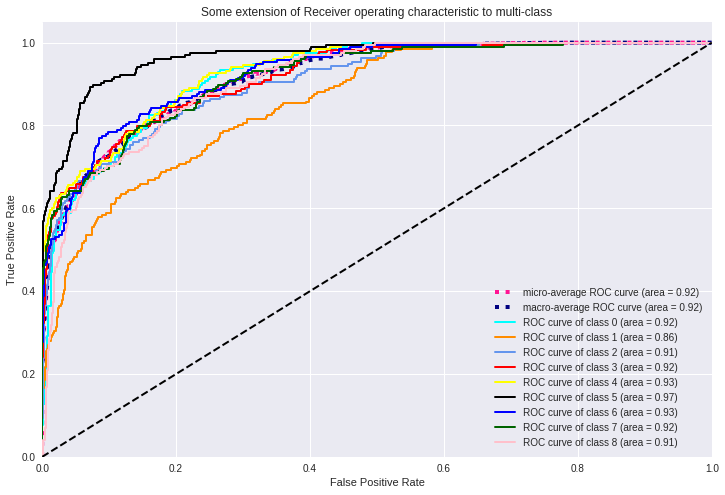

'\n# Zoom in view of the upper left corner.\nplt.figure(2)  \nplt.xlim(0, 0.2)  \nplt.ylim(0.8, 1)  \nplt.plot(fpr["micro"], tpr["micro"],  \n         label=\'micro-average ROC curve (area = {0:0.2f})\'\n               \'\'.format(roc_auc["micro"]),\n         color=\'deeppink\', linestyle=\':\', linewidth=4)\n\nplt.plot(fpr["macro"], tpr["macro"],  \n         label=\'macro-average ROC curve (area = {0:0.2f})\'\n               \'\'.format(roc_auc["macro"]),\n         color=\'navy\', linestyle=\':\', linewidth=4)\n\ncolors = cycle([\'aqua\', \'darkorange\', \'cornflowerblue\'])  \nfor i, color in zip(range(3), colors):  \n    plt.plot(fpr[i], tpr[i], color=color, lw=lw,\n             label=\'ROC curve of class {0} (area = {1:0.2f})\'\n             \'\'.format(i, roc_auc[i]))\n\nplt.plot([0, 1], [0, 1], \'k--\', lw=lw)  \nplt.xlabel(\'False Positive Rate\')  \nplt.ylabel(\'True Positive Rate\')  \nplt.title(\'Some extension of Receiver operating characteristic to multi-class\')  \nplt.leg

In [14]:
# Metrica: Curva ROC y Métrica AUC
from sklearn.datasets import make_classification  
from sklearn.preprocessing import label_binarize  
from scipy import interp  
from itertools import cycle

fig = plt.figure(1, figsize=(12, 8))

n_classes = 9

from sklearn.metrics import roc_curve, auc

# Plot linewidth.
lw = 2

# Compute ROC curve and ROC area for each class
fpr = dict()  
tpr = dict()  
roc_auc = dict()  
for i in range(n_classes):  
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_pred.ravel())  
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Compute macro-average ROC curve and ROC area

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)  
for i in range(n_classes):  
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr  
tpr["macro"] = mean_tpr  
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure(1)  
plt.plot(fpr["micro"], tpr["micro"],  
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],  
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue','red','yellow','black','blue','darkgreen','pink'])  


for i, color in zip(range(n_classes), colors):  
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)  
plt.xlim([0.0, 1.0])  
plt.ylim([0.0, 1.05])  
plt.xlabel('False Positive Rate')  
plt.ylabel('True Positive Rate')  
plt.title('Some extension of Receiver operating characteristic to multi-class')  
plt.legend(loc="lower right")  
plt.show()

"""
# Zoom in view of the upper left corner.
plt.figure(2)  
plt.xlim(0, 0.2)  
plt.ylim(0.8, 1)  
plt.plot(fpr["micro"], tpr["micro"],  
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],  
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])  
for i, color in zip(range(3), colors):  
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)  
plt.xlabel('False Positive Rate')  
plt.ylabel('True Positive Rate')  
plt.title('Some extension of Receiver operating characteristic to multi-class')  
plt.legend(loc="lower right")  
plt.show()  
"""

In [0]:
# Método que permite graficar una matriz de confusión.
import itertools
labels =['Auto', 'Buggy', 'Camion', 'Camioneta', 'Colectivo', 'Cuatriciclo', 'Furgon', 'Moto', 'Pala Cargadora']
def plot_confusion_matrix(cm, classes, normalize=True, title='Confusion matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    #print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    #plt.xticks(tick_marks, classes, rotation=45)
    #plt.yticks(tick_marks, classes)
    plt.xticks(tick_marks, labels, rotation=45)
    plt.yticks(tick_marks, labels)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    
    plt.rcParams["figure.figsize"] = [12, 8]
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Normalized confusion matrix


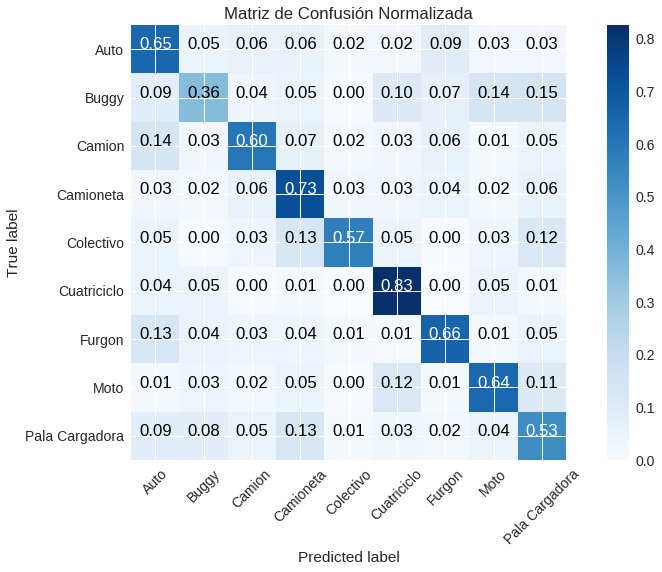

In [35]:
#Creamos la matriz de confusión
from sklearn.metrics import confusion_matrix
import seaborn as sn 

scnn_cm = confusion_matrix(np.argmax(y_test, axis=1), y_predicted)

"""
# Visualiamos la matriz de confusión
scnn_df_cm = pd.DataFrame(scnn_cm, range(9), range(9))  
plt.figure(figsize = (12,8))  
sn.set(font_scale=1.4) #for label size  
sn.heatmap(scnn_df_cm, annot=True, annot_kws={"size": 12}) # font size  
plt.show()  
"""

plot_confusion_matrix(scnn_cm, classes=classes, normalize=True ,title='Matriz de Confusión Normalizada')

Confusion matrix, without normalization


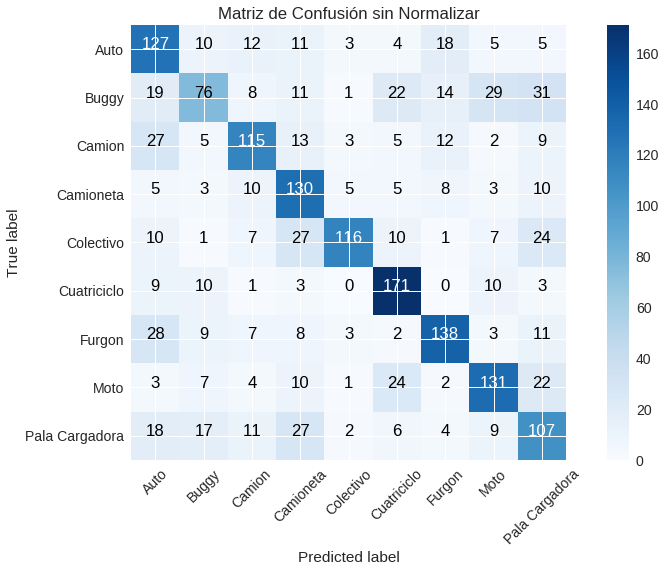

In [37]:
plot_confusion_matrix(scnn_cm, classes=classes, normalize=False ,title='Matriz de Confusión sin Normalizar')

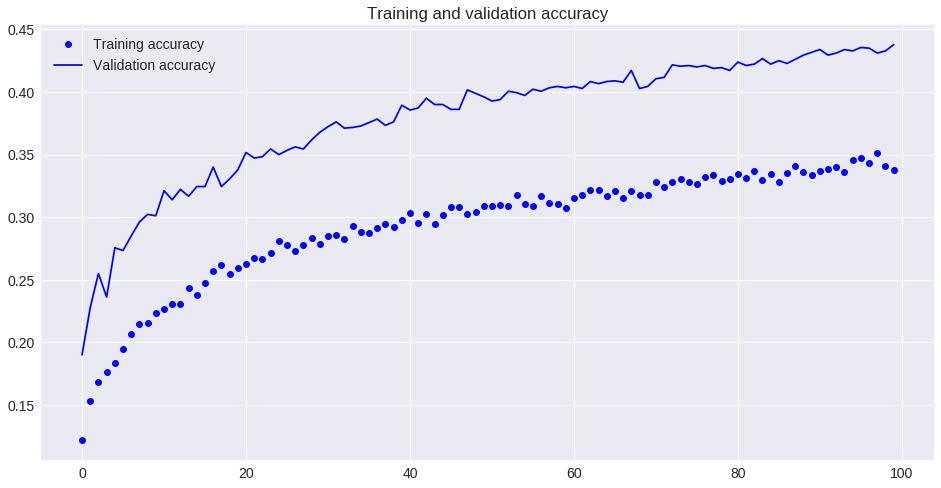

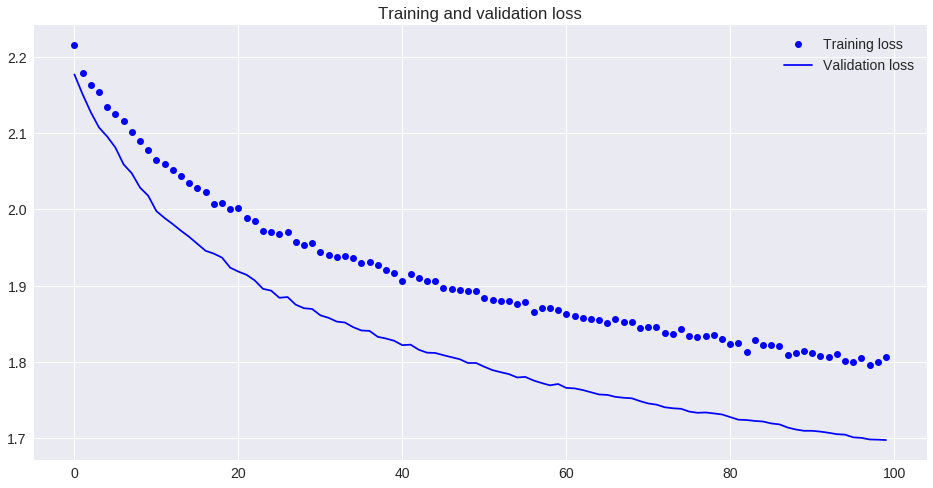

In [185]:
# Graficos
accuracy = vehiculos_train.history['acc']
val_accuracy = vehiculos_train.history['val_acc']
loss = vehiculos_train.history['loss']
val_loss = vehiculos_train.history['val_loss']
epochs = range(len(accuracy))
plt.rcParams['figure.figsize'] = (16, 8) 
plt.plot(epochs, accuracy, 'bo', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()






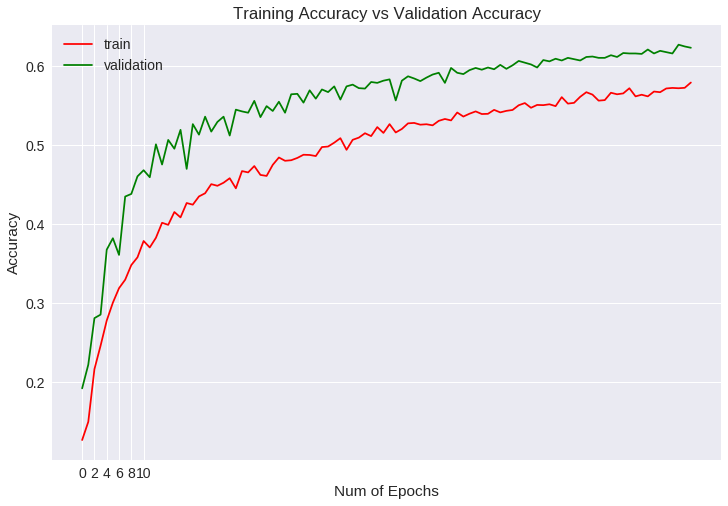

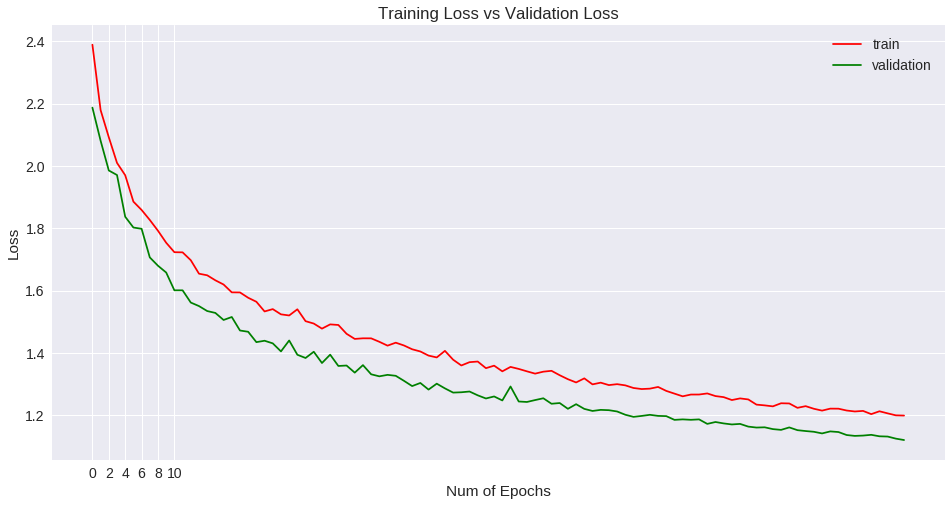

In [47]:
fig.clear()
plt.figure(0)  
plt.plot(vehiculos_train.history['acc'],'r')  
plt.plot(vehiculos_train.history['val_acc'],'g')  
plt.xticks(np.arange(0, 11, 2.0))  
plt.rcParams['figure.figsize'] = (16, 8)  
plt.xlabel("Num of Epochs")  
plt.ylabel("Accuracy")  
plt.title("Training Accuracy vs Validation Accuracy")  
plt.legend(['train','validation'])

plt.figure(1)  
plt.plot(vehiculos_train.history['loss'],'r')  
plt.plot(vehiculos_train.history['val_loss'],'g')  
plt.xticks(np.arange(0, 11, 2.0))  
plt.rcParams['figure.figsize'] = (16, 8)  
plt.xlabel("Num of Epochs")  
plt.ylabel("Loss")  
plt.title("Training Loss vs Validation Loss")  
plt.legend(['train','validation'])

plt.show() 